In [1]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda
from manapy.solvers.advec import AdvectionSolver

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, float_precision="double")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 2.
  w.face[:] = 1.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()

  
  return (domain, ne, u, v, w, P, running_conf)

In [2]:
dim = 2
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
domain, ne, u, v, w, P, conf = init(dim=dim, mesh_path=mesh_file)

S = AdvectionSolver(ne, vel=(u, v), conf=conf)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 105826
Number of Vertices: 53314
Local domain contruction ...


In [3]:
from numba import cuda

def create_var(v):
  if isinstance(v, (int, float, np.int32, np.float32, np.float64)):
    return (v, v)
  return (v, cuda.to_device(v))


S.var.convective[:] = 0.5

host_ne_c, d_ne_c = create_var(S.var.cell)
host_rez_ne, d_rez_ne = create_var(S.var.convective)
host_dissip_ne, d_dissip_ne = create_var(S.var.dissipative)
host_src_ne, d_src_ne = create_var(S.var.source)
host_dtime, d_dtime = (0.1, 0.1)
host_vol, d_vol = create_var(S.domain.cells.volume )



### Cpu Function

In [4]:
#The original function from functions2d.py

from numpy import  int32, float32, float16, uint32
import numpy as np

def update_new_value(ne_c:'float[:]', rez_ne:'float[:]', dissip_ne:'float[:]',  src_ne:'float[:]',
                     dtime:'float', vol:'float[:]'):
    nbelements = len(ne_c)
    for i in range(nbelements):
        ne_c[i]  += dtime  * ((rez_ne[i]  +  dissip_ne[i]) /vol[i] + src_ne[i] )


In [5]:
#? using numba jit -> backend.py
import numba

numba_update_new_value = domain.backend.compile(
  update_new_value, signature=True, target_device='cpu', echo=True)
  
def cpu_update_new_value():
  host_ne_c[:] = 1 #? debug only
  return numba_update_new_value(
    host_ne_c,
    host_rez_ne,
    host_dissip_ne,
    host_src_ne,
    host_dtime,
    host_vol,
  )


compile update_new_value to cpu => signature=(float64[:], float64[:], float64[:], float64[:], float64, float64[:])


In [6]:
#time taken by cpu_update_new_value

initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, domain.cells.center, 2.0)


%timeit cpu_update_new_value()

280 µs ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Cuda Function

In [7]:
def kernel_assign(arr_out: 'float[:]', value : 'float'):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(start, arr_out.shape[0], stride):
        arr_out[i] = value

def kernel_update_new_value(ne_c:'float[:]', rez_ne:'float[:]', dissip_ne:'float[:]',  src_ne:'float[:]',
                     dtime:'float', vol:'float[:]'):

    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(start, ne_c.shape[0], stride):
      v  = dtime  * ((rez_ne[i]  +  dissip_ne[i]) / vol[i] + src_ne[i] )
      cuda.atomic.add(ne_c, i, v)
     

nb_element = len(host_ne_c)
nb_threads = 32
nb_blocks = nb_element // 32 + 1
print(nb_blocks)

kernel_assign = domain.backend.compile(
 kernel_assign, signature=True, target_device='cuda', echo=True, gpu_device=False, gpu_params=(nb_blocks, nb_threads))

kernel_update_new_value = domain.backend.compile(
 kernel_update_new_value, signature=True, target_device='cuda', echo=True, gpu_device=False, gpu_params=(nb_blocks, nb_threads))



def cuda_update_new_value(): 
  kernel_assign(d_ne_c, 1)
  cuda.synchronize()
  kernel_update_new_value(
    d_ne_c,
    d_rez_ne,
    d_dissip_ne,
    d_src_ne,
    d_dtime,
    d_vol,
  )
  cuda.synchronize()

cuda_update_new_value()
test_time(700, cuda_update_new_value)



3308
compile kernel_assign to cuda => signature=void(float64[:], float64)
compile kernel_update_new_value to cuda => signature=void(float64[:], float64[:], float64[:], float64[:], float64, float64[:])
0.36948 ms


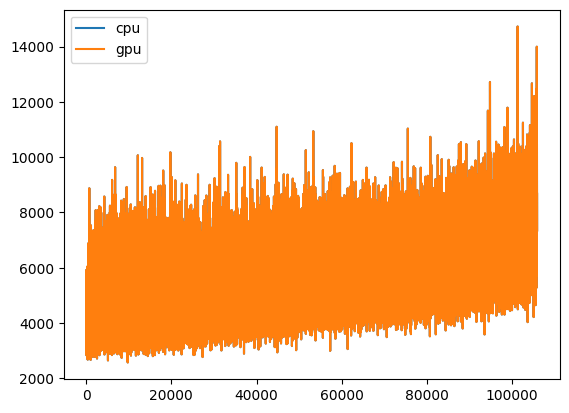

In [8]:
def verify(a, b, decimal, plot):
  if plot == True:
    plt.plot(a, label="cpu")
    plt.plot(b, label="gpu")
    plt.legend()
    plt.show()
  np.testing.assert_almost_equal(a, b, decimal=decimal )

#! float32

verify(host_ne_c, d_ne_c.copy_to_host(), decimal=2, plot=True)